# Conditional Variational AutoEncoder

Conditional Variational AutoEncoder(이하 Conditional VAE)는 조건부 생성모델 중 하나이다. VAE에 조건(condition)이 입력으로 들어가도록 변형하면 Conditional VAE를 손쉽게 구현할 수 있다. Conditinal VAE는 latent space를 조건별로 나눠쓰기 때문에, VAE에 비해 더 좋은 성능을 내는 generative model이다.

* [K. Sohn et al., Learning Structured Output Representation using Deep Conditional Generative Models (NIPS) 2015.](https://papers.nips.cc/paper/5775-learning-structured-output-representation-using-deep-conditional-generative-models)
* [J. Walker et al., An Uncertain Future: Forecasting from Static Images using Variational Autoencoders (ECCV) 2016](https://arxiv.org/abs/1606.07873)


텐서플로우 2.0 기반으로 Conditional VAE를 구현하도록 한다.

본 문서 이외에도 VAE에 대해 상세히 설명되어 있는 좋은 자료들이 많으니, 각자 시간을 내어 반드시 살펴보도록 하자.

* [PR-010: Auto-Encoding Variational Bayes, ICLR 2014, presented by Junbum Cha](https://youtu.be/KYA-GEhObIs)
* [오토인코더의 모든 것 - 1/3, by 이활석 (Naver D2 세미나)](https://youtu.be/o_peo6U7IRM)
* [Conditional Variational Autoencoder: Intuition and Implementation](https://wiseodd.github.io/techblog/2016/12/17/conditional-vae/)
* [Conditional Variational Autoencoders, by Isaac Dykeman](http://ijdykeman.github.io/ml/2016/12/21/cvae.html)
* [D.P. Kingma, Variational Inference and Deep Learning: A New Synthesis, Ph.D. Thesis](https://www.dropbox.com/s/v6ua3d9yt44vgb3/cover_and_thesis.pdf?dl=1)
* [C. Doersch, Tutorial on Variational Autoencoders](https://arxiv.org/abs/1606.05908)



# 참고문헌

TFP를 쓰려면 Tensorflow 2.0 nightly build를 설치해야 함

* [Probabilistic Layers VAE](https://colab.research.google.com/github/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Probabilistic_Layers_VAE.ipynb#scrollTo=eRHjRtAL-e33)
* [Variational Inference in TensorFlow](https://danijar.com/materials/variational-inference-in-tensorflow.pdf)
* [PyMC3](https://docs.pymc.io/)

In [1]:
!pip install -q --upgrade tf-nightly-gpu-2.0-preview
!pip install -q tfp-nightly

    100% |████████████████████████████████| 345.6MB 61kB/s 
    100% |████████████████████████████████| 430kB 10.3MB/s 
    100% |████████████████████████████████| 3.1MB 7.1MB/s 
    100% |████████████████████████████████| 61kB 25.1MB/s 
thinc 6.12.1 has requirement wrapt<1.11.0,>=1.10.0, but you'll have wrapt 1.11.1 which is incompatible.
    100% |████████████████████████████████| 931kB 18.2MB/s 


In [2]:
import tensorflow as tf                       # 텐서플로우 임포트
import tensorflow_probability as tfp


from tensorflow.keras import models, layers   # 케라스 관련 모듈 임포트
import numpy as np

print("Tensorflow: ", tf.__version__)        # 텐서플로우 버전을 확인하도록 한다.
print("Keras: ", tf.keras.__version__)  # 케라스 버전을 확인한다.

print("Tensorflow Probability: ", tfp.__version__)       # TFP 버젼을 확인한다.


Tensorflow:  2.0.0-dev20190421
Keras:  2.2.4-tf
Tensorflow Probability:  0.7.0-dev20190421


In [3]:
# MNIST 데이터 로딩
mnist = tf.keras.datasets.mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalizing the images to the range of [0., 1.]
train_images = train_images / 255.0
test_images = test_images / 255.0

train_images[train_images >= 0.5] = 1.0
train_images[train_images <  0.5] = 0.0
test_images[test_images >= 0.5] = 1.0
test_images[test_images <  0.5] = 0.0

train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

print(train_images.shape)
print(test_images.shape)
print(train_images[0].shape)
print(train_images[0][0][0].dtype)
print(train_labels[0].dtype)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)
(10000, 28, 28)
(28, 28)
float32
uint8


In [4]:
num_classes = 10

train_label_onehots = tf.keras.utils.to_categorical(train_labels, num_classes)
test_label_onehots  = tf.keras.utils.to_categorical(test_labels, num_classes)

# 데이터 변환 확인
print(train_label_onehots.shape)
print(test_label_onehots.shape)

print(train_label_onehots[0])
print(train_labels[0])
print(test_label_onehots[0])
print(test_labels[0])

(60000, 10)
(10000, 10)
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
5
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
7


In [5]:
# 조건(condition)을 텐서에 반영하기 위해, 영상을 나타내는 텐서와 레이블을 나타내는 텐서를 결합(concatenation)시킴
train_tensors = tf.concat([train_images.reshape([-1, 28*28]), train_label_onehots], axis = -1)
test_tensors = tf.concat([test_images.reshape([-1, 28*28]), test_label_onehots], axis = -1)


print(train_tensors.shape)
print(test_tensors.shape) 

(60000, 794)
(10000, 794)


In [0]:
tfd = tfp.distributions


enc_dim = 2
#enc_dim = 10

prior = tfd.Independent(tfd.Normal(loc=tf.zeros(enc_dim), scale=1),
                        reinterpreted_batch_ndims=1)

In [0]:
# encoder (inference model)

## input layers
x = layers.Input(shape=(28,28))
c_onehot = layers.Input(shape=(10,))

## encoding layers
encoder_layer1 = layers.Dense(256, activation='relu')
encoder_layer2 = layers.Dense(128, activation='relu')
encoder_layer3 = layers.Dense( 64, activation='relu')
encoder_layer4 = layers.Dense(enc_dim + enc_dim)
encoder_output_layer = tfp.layers.IndependentNormal(enc_dim, activity_regularizer=tfp.layers.KLDivergenceRegularizer(prior, weight=1))

## encoder network
x_flatten = layers.Flatten()(x)
inputs = layers.concatenate([x_flatten, c_onehot])
x_encoded = encoder_layer1(inputs)
x_encoded = encoder_layer2(x_encoded)
x_encoded = encoder_layer3(x_encoded)
x_encoded = encoder_layer4(x_encoded)
z = encoder_output_layer(x_encoded)

In [0]:
# decoder (generative model)

## decoding layers
decoder_layer1 = layers.Dense( 64, activation='relu')
decoder_layer2 = layers.Dense(128, activation='relu')
decoder_layer3 = layers.Dense(256, activation='relu')
decoder_layer4 = layers.Dense(28*28)
decoder_output_layer = tfp.layers.IndependentBernoulli(event_shape=(28,28), convert_to_tensor_fn=tfd.Bernoulli.logits)

## decoder network
z_cond = layers.concatenate([z, c_onehot])
x_decoded = decoder_layer1(z_cond)
x_decoded = decoder_layer2(x_decoded)
x_decoded = decoder_layer3(x_decoded)
x_decoded = decoder_layer4(x_decoded)
y = decoder_output_layer(x_decoded)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 784)          0           input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 794)          0           flatten[0][0]                    
                                                                 input_2[0][0]                

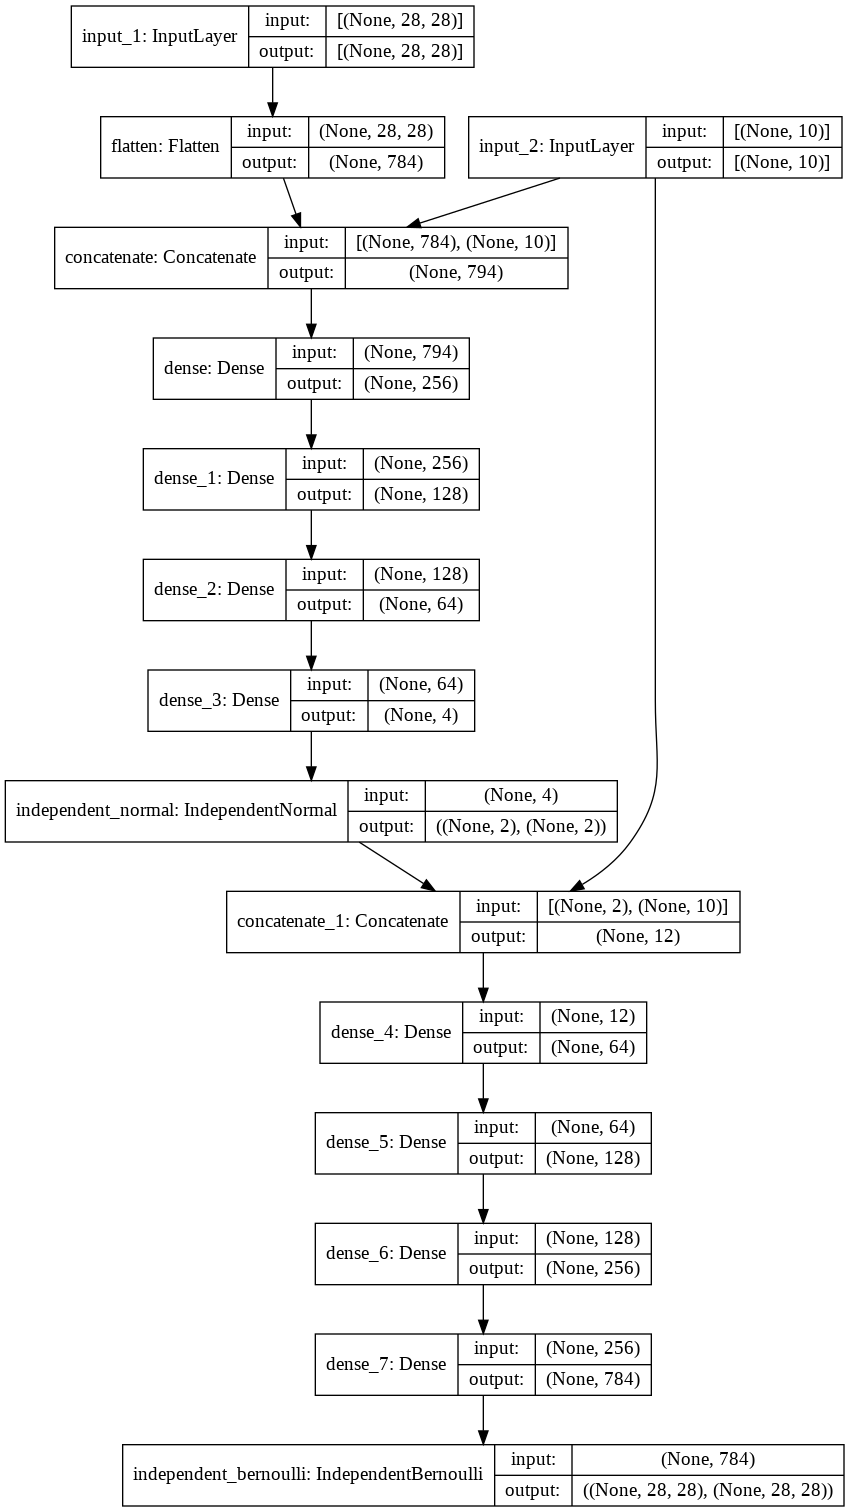

In [9]:
# loss
cvae = models.Model([x, c_onehot], y)
cvae.compile(optimizer='adam',
             loss=lambda y_true, y_pred: -y_pred.log_prob(y_true),
             metrics=['mae'])


cvae.summary()
tf.keras.utils.plot_model(cvae, 'cvae_model.png', show_shapes=True)

In [10]:
epochs = 20
batch_size = 100

cvae.fit([train_images, train_label_onehots], train_images, epochs=epochs, batch_size=batch_size)

Epoch 1/20
60000/60000 [==============================] - 4s 74us/sample - loss: 176.3764 - mae: 5.7222
Epoch 2/20
60000/60000 [==============================] - 4s 59us/sample - loss: 141.6022 - mae: 7.5147
Epoch 3/20
60000/60000 [==============================] - 4s 59us/sample - loss: 136.4823 - mae: 7.8783
Epoch 4/20
60000/60000 [==============================] - 3s 57us/sample - loss: 134.1551 - mae: 8.0345
Epoch 5/20
60000/60000 [==============================] - 3s 53us/sample - loss: 132.6715 - mae: 8.1474
Epoch 6/20
60000/60000 [==============================] - 3s 54us/sample - loss: 131.5063 - mae: 8.2247
Epoch 7/20
60000/60000 [==============================] - 3s 53us/sample - loss: 130.5361 - mae: 8.3207
Epoch 8/20
60000/60000 [==============================] - 3s 54us/sample - loss: 129.8451 - mae: 8.4178
Epoch 9/20
60000/60000 [==============================] - 3s 54us/sample - loss: 129.2497 - mae: 8.4831
Epoch 10/20
60000/60000 [==============================] - 3s 55

In [0]:
yhat = cvae([train_images, train_label_onehots])

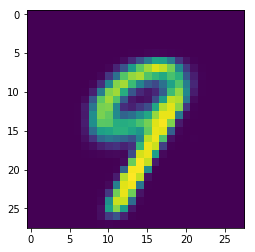

In [12]:
assert isinstance(yhat, tfd.Distribution)

import matplotlib.pyplot as plt

img = yhat.mean()[2140].numpy()
plt.imshow(img)

In [0]:
## input layer (special purposes for conditional generative model)
z_sample = layers.Input(shape=(enc_dim,))


## conditional generative model
z_cond = layers.concatenate([z_sample, c_onehot])
x_decoded = decoder_layer1(z_cond)
x_decoded = decoder_layer2(x_decoded)
x_decoded = decoder_layer3(x_decoded)
x_decoded = decoder_layer4(x_decoded)
y = decoder_output_layer(x_decoded)

cond_encoder = models.Model([x, c_onehot], z)
cond_decoder = models.Model([z_sample, c_onehot], y)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 784)          0           input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 794)          0           flatten[0][0]                    
                                                                 input_2[0][0]              

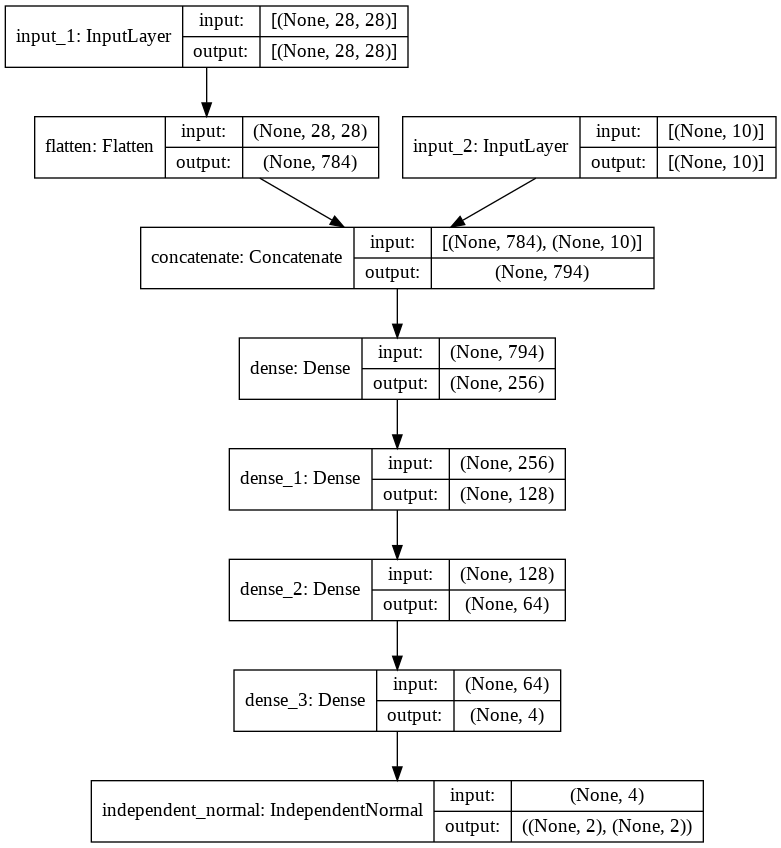

In [14]:
cond_encoder.summary()
tf.keras.utils.plot_model(cond_encoder, 'cond_encoder_model.png', show_shapes=True)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 12)           0           input_3[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 64)           832         concatenate_2[0][0]        

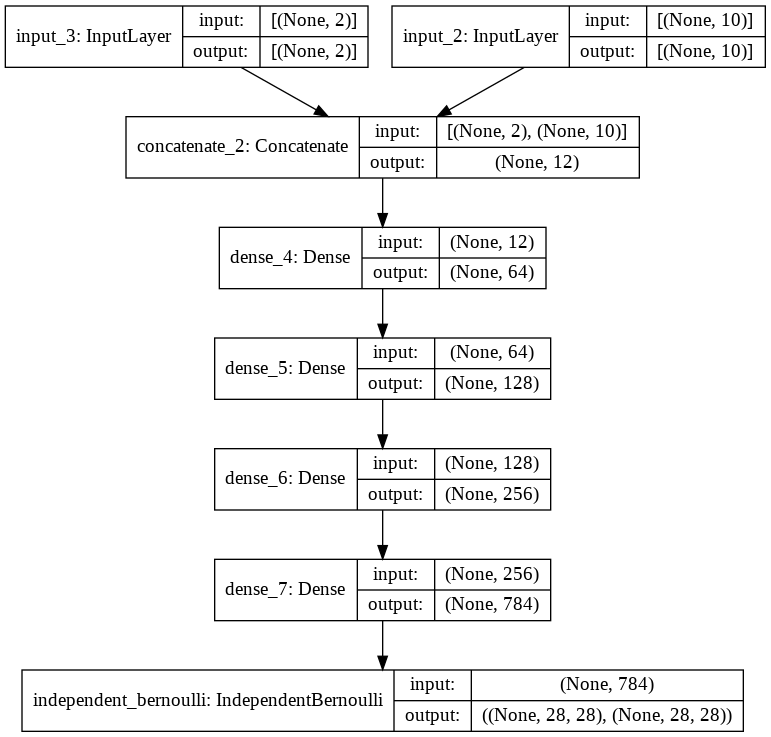

In [15]:
cond_decoder.summary()
tf.keras.utils.plot_model(cond_decoder, 'cond_decoder_model.png', show_shapes=True)

In [0]:
zhat = cond_encoder([train_images, train_label_onehots])


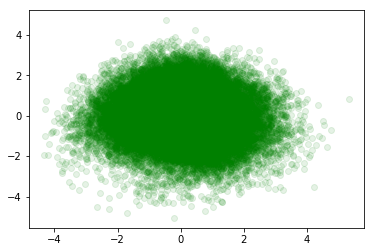

In [17]:
import matplotlib.pyplot as plt

pt = zhat.sample().numpy()

plt.plot(pt[:,0], pt[:,1], "go", alpha=0.1)

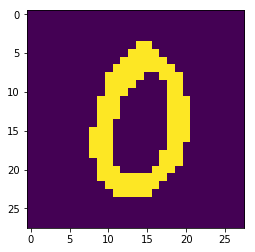

In [18]:
yhat = cond_decoder([zhat.sample(), train_label_onehots])

import matplotlib.pyplot as plt

img = yhat.mode()[1000].numpy()
plt.imshow(img)